## Explore Gulf of Tehuantepec extreme wind events and ocean response 

Notebook to read, condition and resample,  and plot various NASA cloud optimized earth science datasets created with virtualizarr 

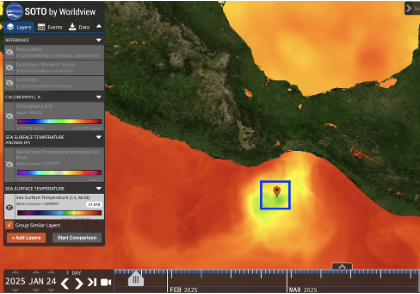 

Gulf of Tehuantepec SST response, January 24 2025. Image source: https://worldview.earthdata.nasa.gov/?v=-108.72259017741943,7.33173524018812,-78.34905371495425,20.763067902309658&l=Reference_Labels_15m(hidden),Reference_Features_15m(hidden),Coastlines_15m,GHRSST_L4_MUR_Sea_Surface_Temperature,VIIRS_NOAA21_CorrectedReflectance_TrueColor(hidden),VIIRS_NOAA20_CorrectedReflectance_TrueColor(hidden),VIIRS_SNPP_CorrectedReflectance_TrueColor(hidden),MODIS_Aqua_CorrectedReflectance_TrueColor(hidden),MODIS_Terra_CorrectedReflectance_TrueColor(hidden)&lg=true&t=2025-01-24-T03%3A09%3A40Z

Gulf of Tehuantepec wind event, January 11-12, 2011

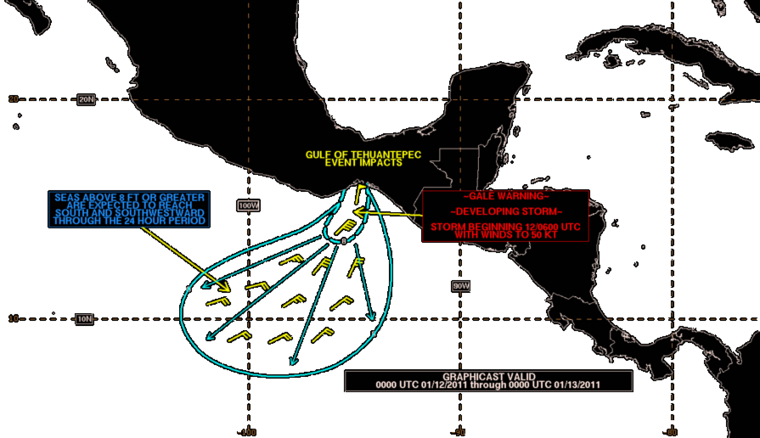

Image source https://en.wikipedia.org/wiki/Tehuantepecer


## Import Packages
#### ***Note using Zarr Version 2***
Successfully tested with the following critical component versions: 
kerchunk==0.2.7,
virtualizarr--1.3.2,
xarray==2025.4.0
zarr==2.18.7

In [2]:
#pip install earthaccess==0.13.0 zarr==2.18.7 fastparquet==2024.5.0 xarray==2025.4.0 fsspec==2024.10.0 "dask[complete]"==2024.5.2 h5netcdf==1.3.0 ujson==5.10.0 matplotlib==3.9.2  kerchunk==0.2.7 virtualizarr==1.3.2  cftime cartopy

In [1]:
pip list | grep -E "zarr|xarray|virtualizarr|kerchunk|earthaccess"

earthaccess               0.13.0
kerchunk                  0.2.7
virtualizarr              1.3.2
xarray                    2025.4.0
zarr                      2.18.7
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
import numpy as np

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Other
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Other Setup

In [3]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

## 1. Obtaining credentials and generating a VDS mapper
The first step is to find the S3 or https endpoints to the files. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we use the `earthaccess` package for its ease of use. 

In [4]:
# Get Earthdata creds
earthaccess.login()

Enter your Earthdata Login username:  edward.m.armstrong
Enter your Earthdata password:  ········


In the next step we define a generic VDS wrapper and that can be wrapped into a function (no modification needed). The mapper will contain all the required access credentials and can be passed directly to xarray. In the future this step will likely be built into to earthaccess but for now we must define it in the notebook. The only inputs to the function are:

    1. The link to the VDS reference file.
    2. Whether or not you are accessing the data in the cloud in the same region as the data. For most beginning users this argument will be set to False.

In [5]:
def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtudal dataset mapper that can be passed to xarray. 
    
    * vds_link: str, link to the mapper
    * in_cloud_region: bool, True if in cloud in the same region as the data, 
        False otherwise.
    """

    if in_cloud_region:
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        fs_data = earthaccess.get_fsspec_https_session()
        remote_protocol = "https"
    
    storage_opts = {"fo": vds_link, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')

## 2. Open reference files 

### OSTIA Daily Sea Surface Temperature (OSTIA-UKMO-L4-GLOB-REP-v2.0)

In [6]:
%%time
# Open the OSTIA Reprocessed SST reference file (OSTIA-UKMO-L4-GLOB-REP-v2.0)
vds_link = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_https.json'
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)


CPU times: user 569 ms, sys: 166 ms, total: 735 ms
Wall time: 3.36 s


In [7]:
%%time

## No modification needed. Read as xarray dataset.
sst_ds = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
print(sst_ds)
sst_ds


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)
CPU times: user 600 ms, sys: 24.9 ms, total: 625 ms
Wall time: 644 ms


<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (39)

### CCMP 6 Hourly Ocean Winds (CCMP_WINDS_10M6HR_L4_V3.1)

In [8]:
%%time

# Open the CCMP Winds reference file (CCMP_WINDS_10M6HR_L4_V3.1)
vds_link = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/CCMP_WINDS_10M6HR_L4_V3.1/CCMP_WINDS_10M6HR_L4_V3.1_virtual_https.json'
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

wind_ds = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
print(wind_ds)
wind_ds

<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)
CPU times: user 600 ms, sys: 64 ms, total: 664 ms
Wall time: 2.11 s


<xarray.Dataset> Size: 781GB
Dimensions:    (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * time       (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:00:00
Data variables:
    nobs       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd       (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws         (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)

In [13]:
# Determine and append the wind direction to the wind_ds dataset

# Calculate wind direction in degrees using arctan2(-u, -v)
wind_dir = np.arctan2(-wind_ds.uwnd, -wind_ds.vwnd)  # radians
wind_dir = np.degrees(wind_dir)  # convert to degrees
wind_dir = (wind_dir + 360) % 360  # ensure values are between 0 and 360

# Assign to dataset
wind_ds['wind_direction'] = wind_dir
wind_ds['wind_direction'].attrs.update({
    'units': 'degrees',
    'standard_name': 'wind_from_direction',
    'long_name': 'Wind Direction (meteorological)'
})
wind_ds

<xarray.Dataset> Size: 976GB
Dimensions:         (latitude: 720, longitude: 1440, time: 47056)
Coordinates:
  * latitude        (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 6kB 0.125 0.375 0.625 ... 359.6 359.9
  * time            (time) datetime64[ns] 376kB 1993-01-02 ... 2025-03-31T18:...
Data variables:
    nobs            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    uwnd            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    vwnd            (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    ws              (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    wind_direction  (time, latitude, longitude) float32 195GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (44)

### Region and time window selection

In [9]:
%%time

# Define region 
# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# for datasets that use 0-360 deg lon
lon_range_360 = (lon_min+360, lon_max+360)

# Define the time slice 
start_date = '1993-01-01'
#end_date = '1998-12-31'
end_date = '2002-12-31'
#end_date = '1994-12-31'
time_range =(start_date, end_date)

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 6.2 μs


### Resample spatial SST and Wind Speed means to a common monthly time step and load into memory

In [10]:
%%time

# A concise method to subset, resample, and average the xarray data all on one line
sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)
).mean(["lat", "lon"]).resample(time="1ME").mean().load()

wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

CPU times: user 5min 30s, sys: 33.9 s, total: 6min 4s
Wall time: 3min 38s


### Resample the wind directions means to the same common monthly time step and find the upwelling favorable wind direction and speed times

In [14]:
%%time

# Resample u and v winds (monthly mean)
u_resample = wind_ds.uwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

v_resample = wind_ds.vwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

#  Resample wind direction
wind_dir_resample = wind_ds.wind_direction.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()


CPU times: user 23min 49s, sys: 1min 2s, total: 24min 51s
Wall time: 8min 52s


In [15]:
# Identify upwelling favorable wind direction times (0–120 degrees) and speeds of at least 6.8 m/s
favorable_mask = (wind_dir_resample >= 0 ) & (wind_dir_resample <= 120) & (wind_speed_resample >= 6.8)
favorable_times = wind_dir_resample.time[favorable_mask]

### Check with a plot 

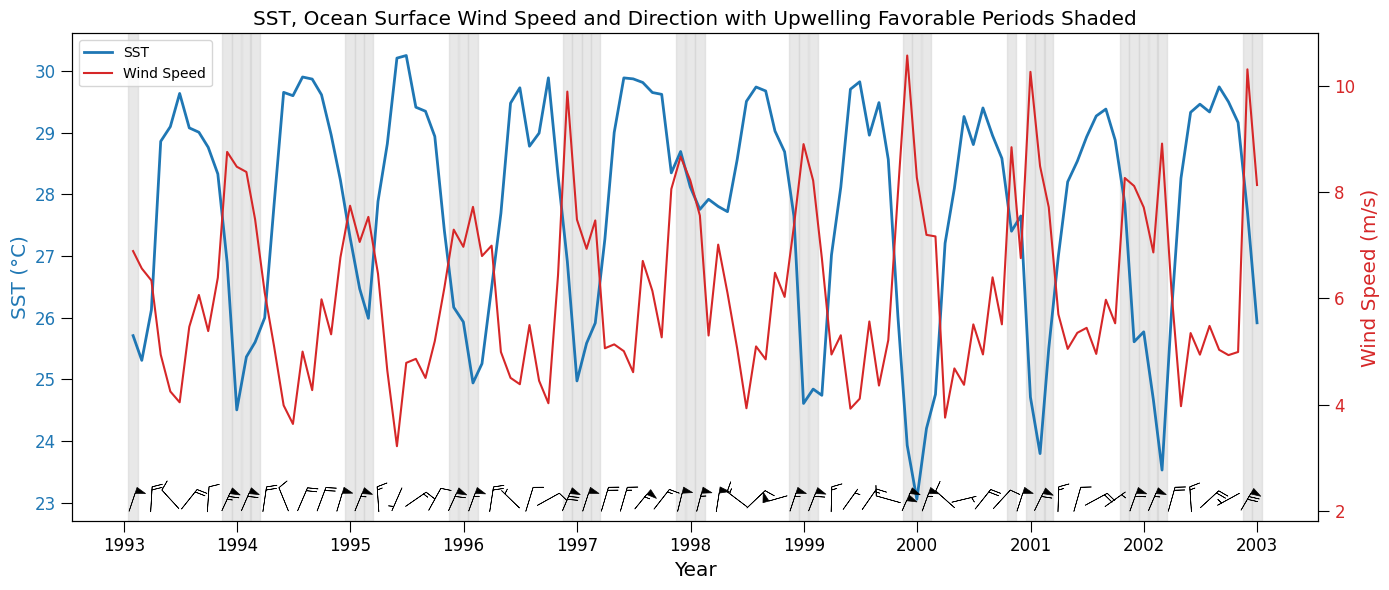

In [16]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°C)', color=color, fontsize='x-large')
ax1.set_xlabel('Year', fontsize='x-large')
ax1.plot(sst_resample['time'], (sst_resample - 273.15), linewidth=2, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)
ax1.tick_params(axis='x',  size=8, labelsize=12)

# Wind Speed Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color, fontsize='x-large')
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)

# Add vertical shaded regions for favorable wind direction periods
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.5)

# Add wind barbs in lower panel (directional vectors)
# Normalize u and v components for visual length
barb_skip = 2  # Plot every nth point to reduce clutter if needed
barb_scale = 30  # Adjust scale for clarity

# Only plot barbs every few months
barb_time = u_resample.time.values[::barb_skip]
u_plot = u_resample.values[::barb_skip]
v_plot = v_resample.values[::barb_skip]

# Set position for barbs slightly below wind speed line
barb_y = np.full_like(u_plot, wind_speed_resample.min().item() - 1)

# Barbs on ax2 (wind axis)
ax2.barbs(barb_time, barb_y, u_plot, v_plot,
          length=6, pivot='middle', barb_increments=dict(half=1, full=2, flag=5),
          color='k', linewidth=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST, Ocean Surface Wind Speed and Direction with Upwelling Favorable Periods Shaded", fontsize='x-large')
fig.tight_layout()
plt.show()

### ECCO Ocean Velocity - Daily Mean 0.5 Degree (Version 4 Release 4) dataset (ECCO_L4_OCEAN_VEL_05DEG_DAILY_V4R4)

In [17]:
%%time

# Open the ECCO Ocean Velocity - Daily Mean 0.5 Degree (Version 4 Release 4) dataset (ECCO_L4_OCEAN_VEL_05DEG_DAILY_V4R4)
vds_link = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_OCEAN_VEL_05DEG_DAILY_V4R4/ECCO_L4_OCEAN_VEL_05DEG_DAILY_V4R4_virtual_https.json'
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

ecco_current_ds = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
print(ecco_current_ds)
ecco_current_ds

<xarray.Dataset> Size: 1TB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EVEL            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    NVEL  

<xarray.Dataset> Size: 1TB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EVEL            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    NVEL            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    WVEL            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (53)

### Resample the ocean vertical velocity means to the same common monthly time step 

In [18]:
%%time

# Do the vertical velocity resampling for the first depth level (5 m below the surface)
depth_min = -5
depth_max = 0
depth_range = (depth_min, depth_max)

vertical_vel_resample = ecco_current_ds.WVEL.sel(longitude=slice(*lon_range), latitude=slice(*lat_range), time=slice(*time_range), Z=slice(0,-5)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

CPU times: user 1min 35s, sys: 3.59 s, total: 1min 38s
Wall time: 47.4 s


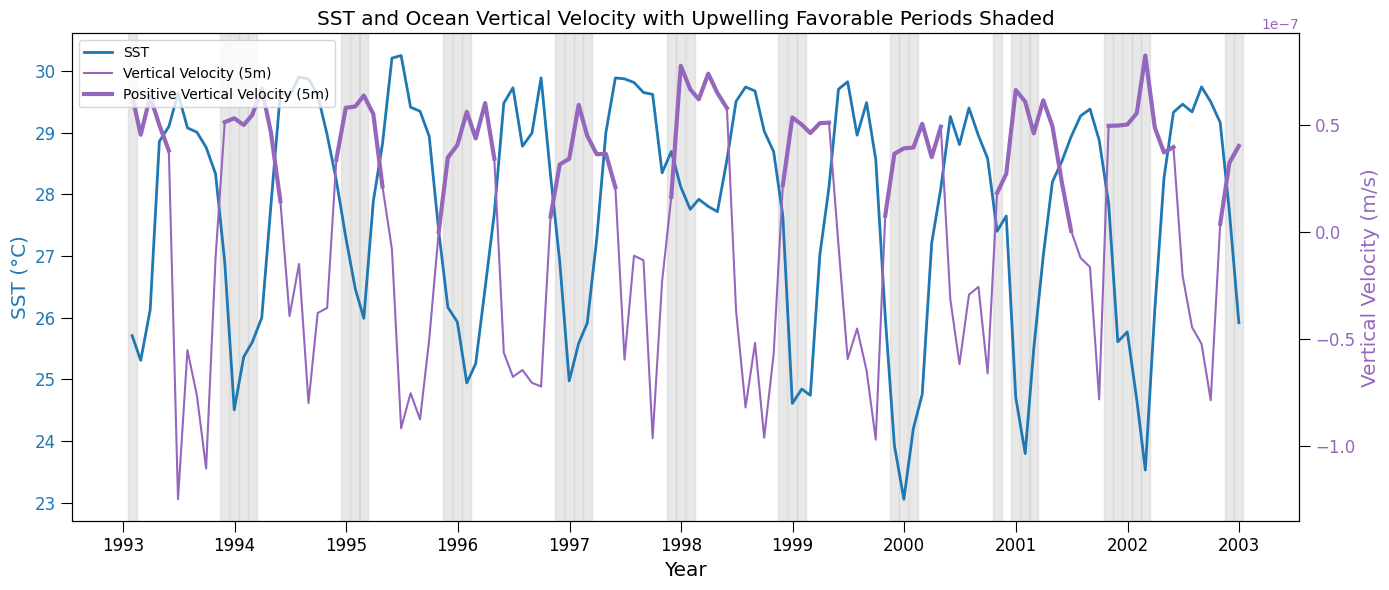

In [19]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°C)', color=color, fontsize='x-large')
ax1.set_xlabel('Year', fontsize='x-large')
ax1.plot(sst_resample['time'], (sst_resample - 273.15), linewidth=2, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)
ax1.tick_params(axis='x',  size=8, labelsize=12)

# Ocean Vertical Velocity  Plot
ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('Vertical Velocity (m/s)', color=color, fontsize='x-large')
ax2.plot(vertical_vel_resample['time'], vertical_vel_resample, color=color, label='Vertical Velocity (5m)')
ax2.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)

# Mask for the positive (upwelling) vertical velocities
positive_mask = (vertical_vel_resample > 0)

# Plot positive velocities (in a highlighted style)
ax2.plot(vertical_vel_resample['time'].where(positive_mask), vertical_vel_resample.where(positive_mask), color=color, linewidth=3, 
         label='Positive Vertical Velocity (5m)')

# Add vertical shaded regions for favorable wind direction periods from previous plot
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST and Ocean Vertical Velocity with Upwelling Favorable Periods Shaded", fontsize='x-large')
fig.tight_layout()
plt.show()

### ECCO Ocean Temperature and Salinity - Daily Mean 0.5 Degree (Version 4 Release 4) dataset (ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4)

In [20]:
%%time

# Open the ECCO Ocean Temperature and Salinity - Daily Mean 0.5 Degree (Version 4 Release 4) dataset (ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4)
vds_link = 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4/ECCO_L4_TEMP_SALINITY_05DEG_DAILY_V4R4_virtual_https.json'
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

ecco_temp_salt_ds = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
print(ecco_temp_salt_ds)
ecco_temp_salt_ds

<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THET

<xarray.Dataset> Size: 985GB
Dimensions:         (time: 9497, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT            (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    THETA           (time, Z, latitude, longitude) float32 492GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (53)

### Resample the ocean surface salinity means to the same common monthly time step 

In [21]:
%%time

# Do the ocean salinity resampling for the first depth level (5 m below the surface)
depth_min = -5
depth_max = 0
depth_range = (depth_min, depth_max)

salt_resample = ecco_temp_salt_ds.SALT.sel(longitude=slice(*lon_range), latitude=slice(*lat_range), time=slice(*time_range), Z=slice(0,-5)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

CPU times: user 1min 20s, sys: 2.78 s, total: 1min 22s
Wall time: 44.9 s


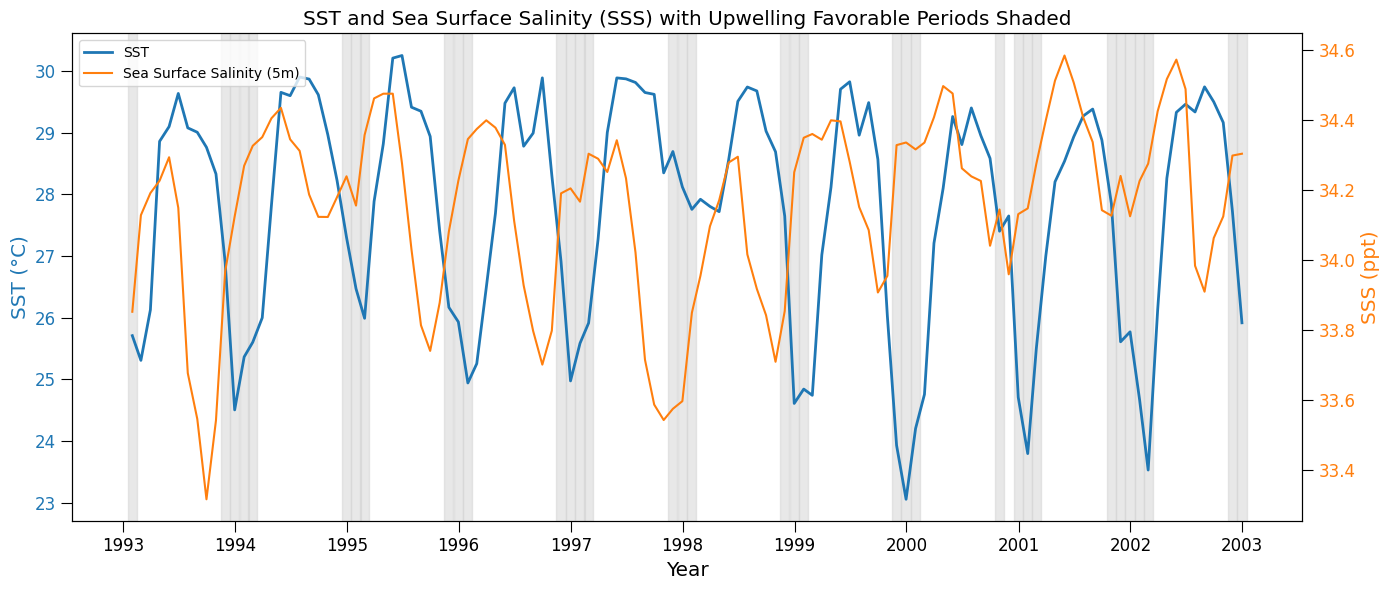

In [22]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°C)', color=color, fontsize='x-large')
ax1.set_xlabel('Year', fontsize='x-large')
ax1.plot(sst_resample['time'], (sst_resample - 273.15), linewidth=2, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)
ax1.tick_params(axis='x',  size=8, labelsize=12)

# Ocean Surface Salinity Plot
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('SSS (ppt)', color=color, fontsize='x-large')
ax2.plot(salt_resample['time'], salt_resample, color=color, label='Sea Surface Salinity (5m)')
ax2.tick_params(axis='y', labelcolor=color, size=8, labelsize=12)


# Add vertical shaded regions for favorable wind direction periods from previous plot
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST and Sea Surface Salinity (SSS) with Upwelling Favorable Periods Shaded", fontsize='x-large')
fig.tight_layout()
plt.show()

### Use parallel processing to speed the resample() implementations

In [23]:
# Set up parallel processing

# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

# Start up cluster and print some information about it:
client = Client(n_workers=32, threads_per_worker=1)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

CPU count = 32
LocalCluster(c6deaf14, 'tcp://127.0.0.1:35297', workers=32, threads=32, memory=122.27 GiB)
View any work being done on the cluster here https://cluster-nwbxl.dask.host/jupyter/proxy/8787/status


In [24]:
%%time

# Execute Tasks: Convert to weekly (1W) monthly (1ME) or annual means (1YE).  
# use load() to load into memory the result

# A concise method to subset, resample, and average the xarray data all on one line
sst_resample = sst_ds.analysed_sst.sel(lon=slice(*lon_range), lat=slice(*lat_range), time=slice(*time_range)
).mean(["lat", "lon"]).resample(time="1ME").mean().load()

wind_speed_resample = wind_ds.ws.sel(longitude=slice(*lon_range_360), latitude=slice(*lat_range), time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

u_resample = wind_ds.uwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

v_resample = wind_ds.vwnd.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

wind_dir_resample = wind_ds.wind_direction.sel(
    longitude=slice(*lon_range_360),
    latitude=slice(*lat_range),
    time=slice(*time_range)
).mean(["latitude", "longitude"]).resample(time="1ME").mean().load()

# vertical velocity
# surface salinity

# Trigger computation with parallel execution....optional
sst_data, wind_speed_data, u_data, v_data, wind_dir_data = da.compute(sst_resample, wind_speed_resample, u_resample, v_resample, wind_dir_resample)

CPU times: user 4min 39s, sys: 47.4 s, total: 5min 26s
Wall time: 13min 50s


### Check with a plot 

In [ ]:
# Identify favorable wind direction times (0–120 degrees) and speeds of at least 6.8 m/s
favorable_mask = (wind_dir_resample >= 0 ) & (wind_dir_resample <= 120) & (wind_speed_resample >= 6.8)
favorable_times = wind_dir_resample.time[favorable_mask]

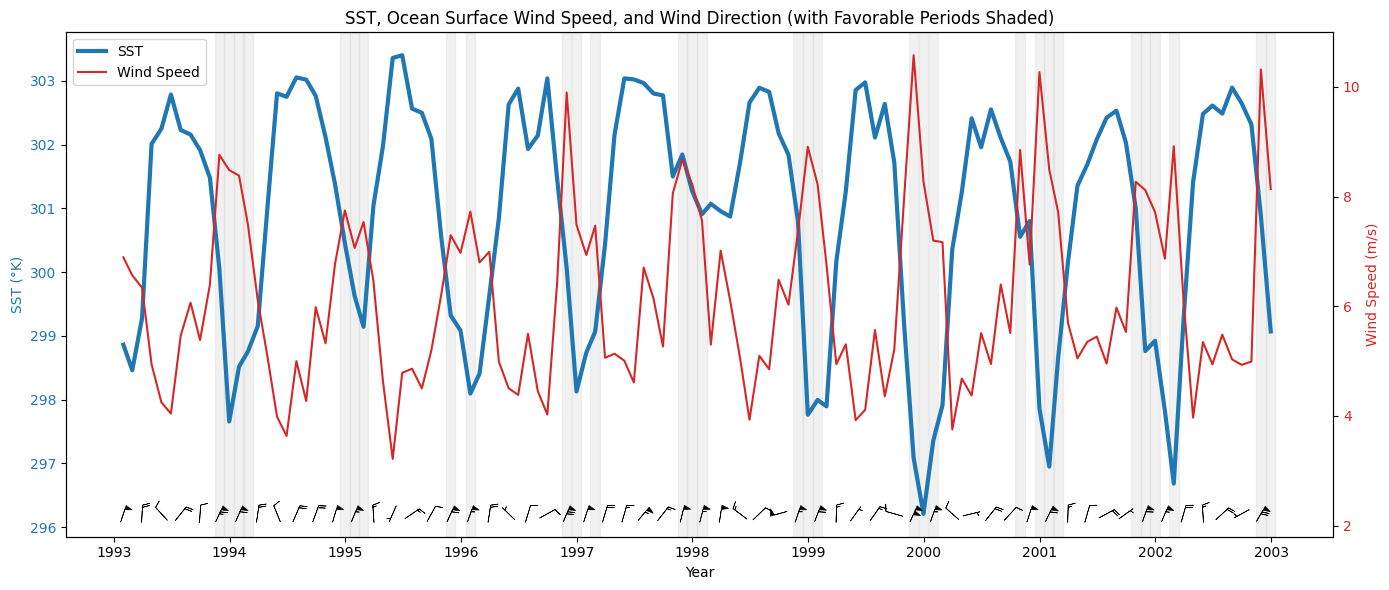

In [20]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# SST Plot
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('SST (°K)', color=color)
ax1.plot(sst_resample['time'], sst_resample, linewidth=2, color=color, label='SST')
ax1.tick_params(axis='y', labelcolor=color)

# Wind Speed Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Wind Speed (m/s)', color=color)
ax2.plot(wind_speed_resample['time'], wind_speed_resample, color=color, label='Wind Speed')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical shaded regions for favorable wind direction periods
for ft in favorable_times.values:
    ax1.axvspan(ft - np.timedelta64(15, 'D'), ft + np.timedelta64(15, 'D'),
                color='lightgray', alpha=0.3)

# Add wind barbs in lower panel (directional vectors)
# Normalize u and v components for visual length
barb_skip = 2  # Plot every nth point to reduce clutter if needed
barb_scale = 30  # Adjust scale for clarity

# Only plot barbs every few months
barb_time = u_resample.time.values[::barb_skip]
u_plot = u_resample.values[::barb_skip]
v_plot = v_resample.values[::barb_skip]

# Set position for barbs slightly below wind speed line
barb_y = np.full_like(u_plot, wind_speed_resample.min().item() - 1)

# Barbs on ax2 (wind axis)
ax2.barbs(barb_time, barb_y, u_plot, v_plot,
          length=5, pivot='middle', barb_increments=dict(half=1, full=2, flag=5),
          color='k', linewidth=0.5)

# Add legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("SST, Ocean Surface Wind Speed, and Wind Direction (with Favorable Periods Shaded)")
fig.tight_layout()
plt.show()